In [269]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
import matplotlib.pyplot as plt
from sklearn import metrics
import collections
import joblib

In [270]:
# filepath：数据集路径，window：序列窗口长度，data_type：训练集or测试集
def load_dataset(filepath, window, data_type): 
    if os.path.exists(filepath) == False:
        print('Error: file %s does not exist.' % file)
        sys.exit(1)
    if window % 2 == 0:
        print('Error: the  window should be an odd number' + '\n\n')
        return 0
    train_data = shuffle(pd.read_csv(filepath))
    split = int((window-1)/2)   # 序列中心位置左右残基的长度
    sequence = []
    for i in range(train_data.shape[0]):
        lineData = train_data.iloc[i]
        seq = []
        seq.append(lineData[0])
        if len(lineData[2]) != 41:
            print('Error: the  window should be 21' + '\n\n')
            return 0
        seq.append(lineData[2][20-split:20+split+1])
        seq.append(lineData[3])
        seq.append(data_type)
        sequence.append(seq)
    return sequence

In [271]:
def EAAC(fastas, window=5):
    if window < 1:
        print('Error: the sliding window should be greater than zero' + '\n\n')
        return 0
    AA = 'ACDEFGHIKLMNPQRSTVWY'
    encodings = []
    header = ['#', 'label']
    for w in range(1, len(fastas[0][1]) - window + 2):
        for aa in AA:
            header.append('SW.' + str(w) + '.' + aa)
    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], i[1], i[2]
        code = [name, label]
        for j in range(len(sequence)):
            if j < len(sequence) and j + window <= len(sequence):
                count = collections.Counter(sequence[j:j + window])
                for key in count:
                    count[key] = count[key] / len(sequence[j:j + window])
                for aa in AA:
                    code.append(count[aa])
        encodings.append(code)
    return encodings

In [272]:
train_path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\与2015年数据比较\2015按物种\Dataset\41window\train.csv'
test_path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\与2015年数据比较\2015按物种\Dataset\41window\test.csv'
window = 41 # 序列窗口长度

In [273]:
# 读取训练、测试数据
train_data = load_dataset(train_path,window,'train')
test_data = load_dataset(test_path,window,'test')

In [274]:
train_encodings = EAAC(train_data)
test_encodings = EAAC(test_data)

In [275]:
def train_test_load(train_encodings,test_encodings) :
    train_encodings = np.delete(np.array(train_encodings),0,axis=0)
    test_encodings = np.delete(np.array(test_encodings),0,axis=0)
    x_train = np.delete(train_encodings,[0,1],axis=1).astype(np.float)
    x_test = np.delete(test_encodings,[0,1],axis=1).astype(np.float)
    y_train = train_encodings[:,1].astype(int)
    y_test = test_encodings[:,1].astype(int)
    return x_train,y_train,x_test,y_test

In [276]:
x_train,y_train,x_test,y_test = train_test_load(train_encodings,test_encodings)

In [277]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015')

In [278]:
out = os.getcwd() + '\\'

In [282]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
kf = KFold(n_splits=5,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    print((val_idx),'=========')
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    #predictor = svm.SVC(gamma='scale', C=1.0, kernel='rbf',class_weight='balanced', probability = True)
    predictor = svm.SVC(C=1.0, kernel='sigmoid', tol=0.001, shrinking=True, probability = True,class_weight='balanced', verbose=False,random_state=None)
    scores1 = predictor.fit(tr_x,tr_y).predict_proba(val_x)[:,1]#进行模型的训练
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1)
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    joblib.dump(predictor, '%s_%d.m' % (out, n_fold))
    #rf.save(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = predictor.predict_proba(x_test)[:,1]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

[  5  10  17  28  29  40  45  50  60  63  88  94  99 110 120 123 127 130
 139 142 145 148 154 157 162 165 166 168 174 177 184 186 190 191 201 206
 211 213 217 233 247 251 262 267 295 324 327 328 332 333 336 340 341 347
 349 350 352 360 362 364 367 368 370 373 386 394 398 404 410 414 415 417
 439 440 441 443 450 456 458 462 464 466 467 475 476 479 483 491 494 498
 503 512 522 523 526 527 530 536 537 541 542 543 546 572 579 580 582 585
 589 596 597 600 604 605 612 615 617 623 626 629 630 632 635 638 640 645
 653 670 671 673 675 678 686 687 696 702 708 710 711 716 724 725 729 731
 735 740 744 751 752 758 760 773 782 786 788 790 801 802 806 811 819 830
 835 840 842 849 855 857 861 864 865 868 870 871 874 879 881 887 891 893
 899 900 901 906 915 921] =========
[  0   2   9  11  12  13  20  25  27  38  51  52  57  61  65  69  70  73
  79  81  84  90  95  97 101 102 103 105 107 112 113 116 117 118 122 140
 144 149 158 170 176 180 182 189 194 209 215 218 219 229 235 239 246 248
 250 252 256 26

In [283]:
#遍历表格求初始里程
#交叉验证
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [284]:
roc_auc_list_val

[0.9836956521739131,
 0.9809782608695652,
 0.9120879120879121,
 0.9684065934065933,
 1.0]

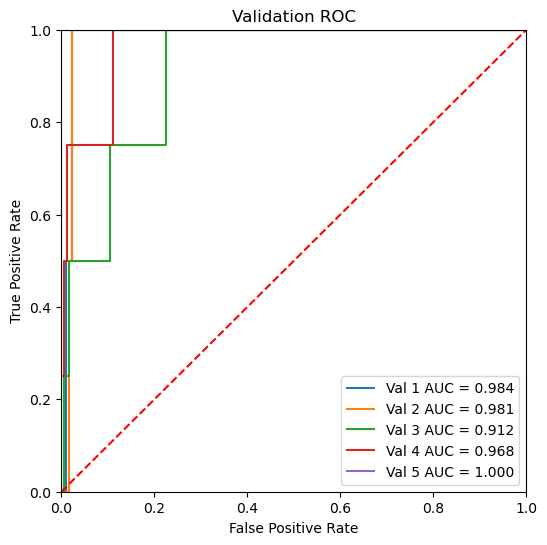

In [285]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('SVM_EAAC_val.png')
plt.show()

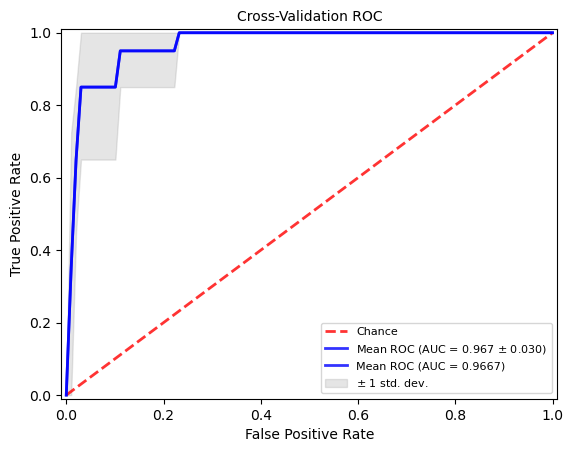

In [286]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('SVM_EAAC_val_mean.png')
plt.show()

In [287]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [288]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [289]:
my_calculate_metrics_list_val

[{'SN': 0.0,
  'SP': 1.0,
  'ACC': 0.989247311827957,
  'MCC': 'NA',
  'Recall': 0.0,
  'Precision': 'NA',
  'F1-score': 0.0,
  'Cutoff': 0.5},
 {'SN': 0.0,
  'SP': 1.0,
  'ACC': 0.989247311827957,
  'MCC': 'NA',
  'Recall': 0.0,
  'Precision': 'NA',
  'F1-score': 0.0,
  'Cutoff': 0.5},
 {'SN': 0.0,
  'SP': 0.9945054945054945,
  'ACC': 0.9731182795698925,
  'MCC': -0.010899546724525694,
  'Recall': 0.0,
  'Precision': 0.0,
  'F1-score': 0.0,
  'Cutoff': 0.5},
 {'SN': 0.25,
  'SP': 1.0,
  'ACC': 0.9838709677419355,
  'MCC': 0.4959293759659191,
  'Recall': 0.25,
  'Precision': 1.0,
  'F1-score': 0.4,
  'Cutoff': 0.5},
 {'SN': 0.5,
  'SP': 1.0,
  'ACC': 0.9946236559139785,
  'MCC': 0.7051930922075863,
  'Recall': 0.5,
  'Precision': 1.0,
  'F1-score': 0.6666666666666666,
  'Cutoff': 0.5}]

In [291]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.00,1.000000,0.989247,NA,0.00,NA,0.000000,0.5
1,0.00,1.000000,0.989247,NA,0.00,NA,0.000000,0.5
2,0.00,0.994505,0.973118,-0.0109,0.00,0.0,0.000000,0.5
3,0.25,1.000000,0.983871,0.495929,0.25,1.0,0.400000,0.5
4,0.50,1.000000,0.994624,0.705193,0.50,1.0,0.666667,0.5


In [292]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

<ipython-input-292-5d2f55dd4019>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_val = performance_val.std(axis = 0,ddof=1)
<ipython-input-292-5d2f55dd4019>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_val = performance_val.mean(axis = 0)


,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.000000,1.000000,0.989247,NA,0.000000,NA,0.000000,0.5
1,0.000000,1.000000,0.989247,NA,0.000000,NA,0.000000,0.5
2,0.000000,0.994505,0.973118,-0.0109,0.000000,0.0,0.000000,0.5
3,0.250000,1.000000,0.983871,0.495929,0.250000,1.0,0.400000,0.5
4,0.500000,1.000000,0.994624,0.705193,0.500000,1.0,0.666667,0.5
0,0.150000,0.998901,0.986022,NaN,0.150000,NaN,0.213333,0.5
0,0.223607,0.002457,0.008154,NaN,0.223607,NaN,0.306956,0.0


In [293]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015\result\SVM_EAAC_performance_val.csv',encoding='utf-8')

独立测试

In [294]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [295]:
roc_auc_list_indep

[1.0, 0.995049504950495, 1.0, 0.9554455445544555, 1.0]

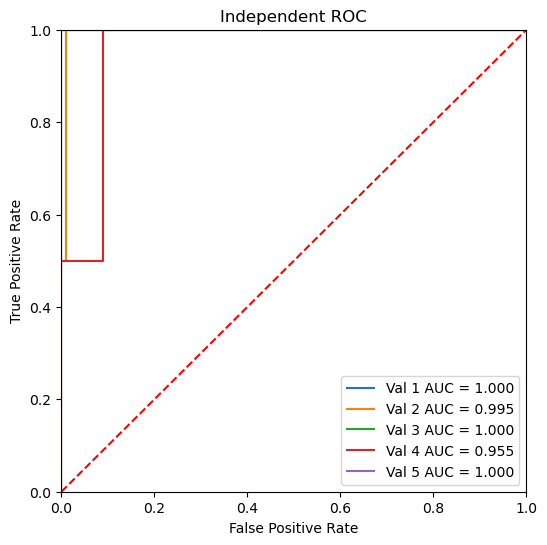

In [296]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('SVM_EAAC_indep.png')
plt.show()

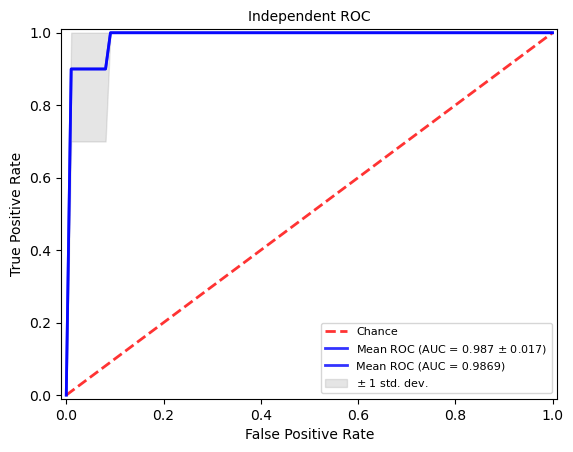

In [297]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('SVM_EAAC_indep_mean.png')
plt.show()

In [298]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [299]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [300]:
my_calculate_metrics_list_indep

[{'SN': 0.0,
  'SP': 1.0,
  'ACC': 0.9805825242718447,
  'MCC': 'NA',
  'Recall': 0.0,
  'Precision': 'NA',
  'F1-score': 0.0,
  'Cutoff': 0.5},
 {'SN': 0.0,
  'SP': 1.0,
  'ACC': 0.9805825242718447,
  'MCC': 'NA',
  'Recall': 0.0,
  'Precision': 'NA',
  'F1-score': 0.0,
  'Cutoff': 0.5},
 {'SN': 0.0,
  'SP': 1.0,
  'ACC': 0.9805825242718447,
  'MCC': 'NA',
  'Recall': 0.0,
  'Precision': 'NA',
  'F1-score': 0.0,
  'Cutoff': 0.5},
 {'SN': 0.0,
  'SP': 1.0,
  'ACC': 0.9805825242718447,
  'MCC': 'NA',
  'Recall': 0.0,
  'Precision': 'NA',
  'F1-score': 0.0,
  'Cutoff': 0.5},
 {'SN': 0.0,
  'SP': 1.0,
  'ACC': 0.9805825242718447,
  'MCC': 'NA',
  'Recall': 0.0,
  'Precision': 'NA',
  'F1-score': 0.0,
  'Cutoff': 0.5}]

In [301]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
1,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
2,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
3,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
4,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5


In [302]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

<ipython-input-302-e218b2739e74>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_indep = performance_indep.std(axis = 0,ddof=1)
<ipython-input-302-e218b2739e74>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_indep = performance_indep.mean(axis = 0)


,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
1,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
2,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
3,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
4,0.0,1.0,0.980583,NA,0.0,NA,0.0,0.5
0,0.0,1.0,0.980583,NaN,0.0,NaN,0.0,0.5
0,0.0,0.0,0.000000,NaN,0.0,NaN,0.0,0.0


In [304]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\ML\SVM_EAAC_2015\result\SVM_EAAC_performance_indep.csv',encoding='utf-8')

In [255]:
def calculate_metrics_list(data, cutoff=0.5, po_label=1):
    metrics_list = []
    for i in data:
        metrics_list.append(calculate_metrics_val(i[1:2], i[0:1], cutoff=cutoff, po_label=po_label))#lable，scroe
    if len(metrics_list) == 1:
        return metrics_list
    else:
        mean_dict = {}
        std_dict = {}
        keys = metrics_list[0].keys()
        for i in keys:
            mean_list = []
            for metric in metrics_list:
                mean_list.append(metric[i])
            mean_dict[i] = np.array(mean_list).sum() / len(metrics_list)
            std_dict[i] = np.array(mean_list).std()
        metrics_list.append(mean_dict)
        metrics_list.append(std_dict)
        return metrics_list

In [260]:
a=b.values
a

array([[3.96200798e-03, 0.00000000e+00],
       [1.92761419e-03, 0.00000000e+00],
       [1.33338958e-02, 0.00000000e+00],
       [3.53312330e-04, 0.00000000e+00],
       [2.07468449e-02, 0.00000000e+00],
       [5.36840859e-04, 0.00000000e+00],
       [3.12710407e-04, 0.00000000e+00],
       [1.60592620e-04, 0.00000000e+00],
       [1.22318333e-04, 0.00000000e+00],
       [1.41980704e-02, 0.00000000e+00],
       [9.02392204e-06, 0.00000000e+00],
       [1.97447797e-04, 0.00000000e+00],
       [5.64229697e-05, 0.00000000e+00],
       [2.06127063e-03, 0.00000000e+00],
       [4.65209340e-01, 0.00000000e+00],
       [3.02698727e-04, 0.00000000e+00],
       [7.32861053e-04, 0.00000000e+00],
       [4.62634009e-03, 0.00000000e+00],
       [1.54791882e-04, 0.00000000e+00],
       [3.35483416e-05, 0.00000000e+00],
       [7.12236534e-03, 0.00000000e+00],
       [2.71302409e-04, 0.00000000e+00],
       [3.04138547e-04, 0.00000000e+00],
       [6.76840069e-04, 0.00000000e+00],
       [4.518604

In [259]:
b=data.iloc[:, 1:] 
b

,0,0.1
0,0.003962,0
1,0.001928,0
2,0.013334,0
3,0.000353,0
4,0.020747,0
...,...,...
181,0.000281,0
182,0.003818,0
183,0.005948,0
184,0.000383,0


In [264]:
a = a.astype(float)
for i in a:
    i[0:1].astype(float)
    print(type(i[0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl